<a href="https://colab.research.google.com/github/Rustam86/HSE-course-project/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Настройка окружения





In [ ]:
!sudo apt-get install unrar

In [ ]:
# Get file with Coronaviridae taxonomy information
!wget https://raw.githubusercontent.com/Rustam86/HSE-course-project/main/Coronaviridae_taxonomic_info.csv

In [ ]:
!pip install biopython
!pip install tqdm
!pip install transformers
!pip install ete3

In [ ]:
# Install MAFFT
!apt-get install mafft

In [4]:
!mafft --version

v7.490 (2021/Oct/30)


In [ ]:
# Install TrimAl
!git clone https://github.com/scapella/trimal.git
%cd trimal/source
!make

In [6]:
!./trimal --version


trimAl v1.4.rev22 build[2015-05-21]



In [ ]:
# Install IQ-TREE (takes some time)
%cd /content
!apt-get install -y libeigen3-dev
!git clone https://github.com/Cibiv/IQ-TREE.git
%cd IQ-TREE
!mkdir build
%cd build
!cmake ..
!make -j4

In [8]:
!./iqtree --version

IQ-TREE multicore version 1.6.12 for Linux 64-bit built Aug 21 2023
Developed by Bui Quang Minh, Nguyen Lam Tung, Olga Chernomor,
Heiko Schmidt, Dominik Schrempf, Michael Woodhams.



In [ ]:
# "Install" ZDNABERT
%cd /content
model = 'HG chipseq'
model_id = '1VAsp8I904y_J0PUhAQqpSlCn1IqfG0FB'

!gdown $model_id
!gdown 10sF8Ywktd96HqAL0CwvlZZUUGj05CGk5
!gdown 16bT7HDv71aRwyh3gBUbKwign1mtyLD2d
!gdown 1EE9goZ2JRSD8UTx501q71lGCk-CK3kqG
!gdown 1gZZdtAoDnDiLQqjQfGyuwt268Pe5sXW0


!mkdir 6-new-12w-0
!mv pytorch_model.bin 6-new-12w-0/
!mv config.json 6-new-12w-0/
!mv special_tokens_map.json 6-new-12w-0/
!mv tokenizer_config.json 6-new-12w-0/
!mv vocab.txt 6-new-12w-0/

In [ ]:
# "Install" ZHUNT
!wget https://raw.githubusercontent.com/Rustam86/HSE-course-project/main/zhunt3-alan.c
!gcc zhunt3-alan.c -lm -o zhunt3
!chmod +x /content/zhunt3

In [149]:
import json
import logging
import os
import random
import sys
import subprocess
import tempfile
import time
from typing import Dict, List, Tuple, Callable, Optional

from ete3 import ClusterTree
from google.colab import files
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import torch
import Bio
from Bio import Entrez, SeqIO
from matplotlib.lines import Line2D
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy import ndimage, stats
import sklearn
from sklearn.linear_model import LinearRegression
import torch
from torch import nn
import tqdm as tq
from tqdm import tqdm
import transformers
from transformers import BertForTokenClassification, BertTokenizer


In [12]:
# Image resolution set to 600 dpi
plt.rcParams["figure.dpi"] = 600

In [13]:
# Printing versions
print(' '.join(f"Python version: {sys.version}".split()[:3]))
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scipy version: {scipy.__version__}")
print(f"Sklearn version: {sklearn.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"Biopython version: {Bio.__version__}")
print(f"TQDM version: {tq.__version__}")
print(f"Transformers version: {transformers.__version__}")

Python version: 3.10.12
Matplotlib version: 3.7.1
Numpy version: 1.23.5
Pandas version: 1.5.3
Scipy version: 1.10.1
Sklearn version: 1.2.2
Torch version: 2.0.1+cu118
Seaborn version: 0.12.2
PyTorch version: 2.0.1+cu118
Biopython version: 1.81
TQDM version: 4.66.1
Transformers version: 4.31.0


# Филогенетический анализ

In [14]:
# Read the CSV using the correct delimiter ';'
taxa_db = pd.read_csv("/content/Coronaviridae_taxonomic_info.csv", encoding='ISO-8859-1', delimiter=';')

In [15]:
taxa_db.head()

,Unnamed: 0,Subfamily,Genus,Subgenus,Species,Virus name,Isolate,Accession,Available sequence,Abbrev.,Prevalent host,Virus Count
0,1,Letovirinae,Alphaletovirus,Milecovirus,Microhyla letovirus 1,Microhyla letovirus 1,NaN,GECV01031551,Partial genome,MLeV,Frog,0.0
1,2,Orthocoronavirinae,Alphacoronavirus,Amalacovirus,Alphacoronavirus AMALF,bat alphacoronavirus isolate AMA_L_F,AMA_L_F,MT663548,Complete genome,BtCoV-AMA-L-F,Bats,0.0
2,3,Orthocoronavirinae,Alphacoronavirus,Colacovirus,Bat coronavirus CDPHE15,bat coronavirus CDPHE15,bat/USA/CDPHE15/2006,KF430219,Complete genome,BtCoV CDPHE15,Bats,3.0
3,4,Orthocoronavirinae,Alphacoronavirus,Decacovirus,Alphacoronavirus CHB25,Hipposideros pomona bat coronavirus CHB25,CHB0025,MN611525,Complete genome,HipPBCoV-CHB25,Bats,2.0
4,5,Orthocoronavirinae,Alphacoronavirus,Decacovirus,Alphacoronavirus WA3607,alphacoronavirus sp. WA3607,WA3607,MK472070,Complete genome,ACoV-WA3607,Bats,0.0


In [16]:
def fetch_gb_files(accession_list, email, output_dir="."):
    """
    Fetch GB files for a list of accession numbers.

    Parameters:
    - accession_list: List of accession numbers.
    - email: Your email address. NCBI requires this to track usage.
    - output_dir: Directory to save the GB files. Default is the current directory.

    Returns:
    None. GB files are saved to the specified directory.
    """
    Entrez.email = email

    for accession in accession_list:
        handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
        filename = f"{output_dir}/{accession}.gb"
        with open(filename, "w") as f:
            f.write(handle.read())
        handle.close()
        print(f"{accession}.gb saved to {output_dir}")

In [ ]:
# Dowload refseq gb files from genbank
%cd /content
!mkdir refseqs

accession_list = taxa_db['Accession']
fetch_gb_files(accession_list, email=Entrez.email, output_dir="/content/refseqs")

In [18]:
def list_proteins(gb_file):
    """
    List all protein names from a GB file.

    Parameters:
    - gb_file: Path to the GenBank file.

    Returns:
    List of protein names.
    """
    protein_names = []

    # Parse the GenBank file
    for record in SeqIO.parse(gb_file, "genbank"):
        for feature in record.features:
            if feature.type == "CDS" and "product" in feature.qualifiers:
                protein_names.append(feature.qualifiers["product"][0])

    return protein_names

In [ ]:
directory = '/content/refseqs'
file_paths = [os.path.join(directory, file)
              for file in os.listdir(directory)
              if os.path.isfile(os.path.join(directory, file))]

protein_names_list = []

for gb_file in file_paths:
  protein_names_list.extend(list_proteins(gb_file))

unique_protein_names = sorted(set(protein_names_list))
print(unique_protein_names)

In [20]:
def extract_protein_sequence(gb_file, protein_name):
    """
    Extract amino acid sequence from a GB file given the name of a protein.

    Parameters:
    - gb_file: Path to the GenBank file.
    - protein_name: Name of the protein to extract the sequence for.

    Returns:
    Amino acid sequence as a string if found, else None.
    """
    # Parse the GenBank file
    for record in SeqIO.parse(gb_file, "genbank"):
        for feature in record.features:
            if feature.type == "CDS":
                # Check if the protein product name matches the given name
                if "product" in feature.qualifiers and feature.qualifiers["product"][0] == protein_name:
                    # Extract the protein sequence
                    return feature.qualifiers["translation"][0]
    return None

In [21]:
# All nucleocapsid protein aliases used in gb annotations
protein_names = ['nucleocapsid',
'nucleocapsid phosphoprotein',
'nucleocapsid protein',
'nucleoprotein',
'N',
'N protein',
'capsid']

In [22]:
directory = '/content/refseqs'
file_paths = [os.path.join(directory, file)
              for file in os.listdir(directory)
              if os.path.isfile(os.path.join(directory, file))]
seq_names = []
sequences = []
for gb_file in file_paths:
  for pr in protein_names:
    seq = extract_protein_sequence(gb_file, pr)
    if seq:
      seq_names.append(gb_file.split('/')[3][:-3])
      sequences.append(seq)

In [23]:
# Two species are missing, no protein annotations
missing = [i.split('/')[3][:-3] for i in file_paths if i.split('/')[3][:-3] not in seq_names]
print(missing)

['GECV01031551', 'AY613950']


In [24]:
def write_to_fasta(seq_names, sequences, filename):
    """
    Write sequences to a FASTA file.

    Parameters:
    - seq_names: List of sequence names.
    - sequences: List of corresponding sequences.
    - filename: Name of the output FASTA file.

    Returns:
    None. Writes the sequences to the specified FASTA file.
    """
    with open(filename, 'w') as f:
        for name, seq in zip(seq_names, sequences):
            f.write(f">{name}\n{seq}\n")

In [ ]:
%cd /content

In [26]:
# Combine nucleocapsid protein sequences inta a single fasta file
write_to_fasta(seq_names, sequences, 'ref_sequences_nucleocapsid.fas')

In [ ]:
# Multiple sequence alignment
!mafft --auto /content/ref_sequences_nucleocapsid.fas > /content/ref_sequences_nucleocapsid_aln.fas

In [28]:
# Alignment trimming
!trimal/source/trimal -in /content/ref_sequences_nucleocapsid_aln.fas \
                      -out /content/ref_sequences_nucleocapsid_aln_trimm.fas \
                      -automated1

In [ ]:
# Substitution model estimation and tree building
%cd /content/IQ-TREE/build
!./iqtree -nt AUTO -s /content/ref_sequences_nucleocapsid_aln_trimm.fas -m TEST
%cd /content

# Анализ участков Z-РНК референсных штаммов

In [30]:
# Generic function to run other sequence processing functions

def process_fasta_with_function(fasta_path: str, function: Callable, params: Dict) -> Dict[str, List[Tuple[int, int]]]:
    """
    Run a function on a multi-fasta file.

    Parameters:
    - fasta_path (str): The path to the fasta file.
    - function (Callable): The function to run on each sequence.
    - params (Dict): A dictionary containing the parameters for the function.

    Returns:
    Dict[str, List[Tuple[int, int]]]: A dictionary where the keys are the sequence
    identifiers and the values are the results of the function for each sequence.
    """
    results = {}

    # Load all the sequences into a list to compute the total number of sequences
    sequences = list(SeqIO.parse(fasta_path, "fasta"))

    # Wrap the sequences list with tqdm for progress bar
    with tqdm(sequences, desc="Processing", unit="sequence") as pbar:
        for record in pbar:
            sequence_id = record.id
            sequence = str(record.seq)
            results[sequence_id] = function(sequence, **params)

    return results

In [31]:
# Function to predict Z-RNA regions with ZDNABERT
def run_zdnabert(seq_string: str, model:
                 torch.nn.Module, tokenizer: torch.nn.Module,
                 model_confidence_threshold: float = 0.2,
                 minimum_sequence_length: int = 10) -> List[Tuple[int, int]]:
    """
    Process a DNA or RNA sequence string using a given model and identify segments of significance.

    Parameters:
    - seq_string (str): The DNA or RNA sequence to be processed.
    - model (torch.nn.Module): Pretrained model for sequence prediction.
    - tokenizer (torch.nn.Module): Tokenizer to convert the sequence into model-compatible tokens.
    - model_confidence_threshold (float, optional): Threshold for considering a segment significant. Defaults to 0.2.
    - minimum_sequence_length (int, optional): Minimum length of a segment to consider. Defaults to 10.

    Returns:
    List[Tuple[int, int]]: A list of tuples representing the start and end positions
    of the predicted Z-DNA forming regions.
    """

    model.cuda()
    # Convert the sequence to k-mers
    k = 6
    kmer_seq = [seq_string.upper()[x:x+k] for x in range(len(seq_string)+1-k)]

    # Split the kmer sequence into pieces of a specified length with some overlap (padding)
    length, pad = 512, 16
    seq_pieces = [kmer_seq[st:min(st+512, len(kmer_seq))] for st in range(0, len(kmer_seq), length-pad)]

    # Use the model to predict on each sequence piece
    preds = []
    with torch.no_grad():
        for seq_piece in seq_pieces:
            input_ids = torch.LongTensor(tokenizer.encode(' '.join(seq_piece), add_special_tokens=False))
            outputs = torch.softmax(model(input_ids.cuda().unsqueeze(0))[-1], axis=-1)[0, :, 1]
            preds.append(outputs.cpu().numpy())

    # Stitch together the predictions for each piece of the sequence
    res = np.array([])
    for seq in preds:
        res = np.concatenate([res[:-pad], seq])
    stitched_seq = res

    # Identify segments with prediction confidence above the threshold
    out = []
    labeled, max_label = scipy.ndimage.label(stitched_seq > model_confidence_threshold)
    for label in range(1, max_label+1):
        candidate = np.where(labeled == label)[0]
        candidate_length = candidate.shape[0]
        # Consider segments only if they are longer than the specified minimum sequence length
        if candidate_length > minimum_sequence_length:
            out.append((candidate[0], candidate[-1]))

    return out


In [32]:
# Function to predict Z-RNA regions with ZHUNT
def run_zhunt(seq_string: str, zhunt_path: str, score: int = 500,
              window_size: int = 6, min_size: int = 3,
              max_size: int = 6) -> List[Tuple[int, int]]:
    """
    Run the ZHunt program to predict Z-DNA forming regions in a DNA sequence.

    Parameters:
    - seq_string (str): The DNA or RNA sequence to be processed.
    - zhunt_path (str): The path to the ZHunt executable.
    - window_size (int): The window size for the ZHunt program. Default is 6.
    - min_size (int): The minimum size for the ZHunt program. Default is 3.
    - max_size (int): The maximum size for the ZHunt program. Default is 6.

    Returns:
    List[Tuple[int, int]]: A list of tuples representing the start and end positions
    of the predicted Z-DNA forming regions.
    """
    # Ensure the sequence only contains valid DNA bases
    # assert set(sequence).issubset({"A", "C", "G", "T", "N"}), "Invalid DNA sequence"

    # Create a temporary file
    file_descriptor, temp_file_path = tempfile.mkstemp()
    os.close(file_descriptor)

    try:
        # Write the sequence to the temporary file
        with open(temp_file_path, 'w') as temp_file:
            temp_file.write(seq_string)

        # Run the ZHunt program
        subprocess.run(
            [zhunt_path, str(window_size), str(min_size), str(max_size), temp_file_path],
            check=True, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL,
            input=seq_string, encoding='ascii'
        )

        # Read the ZHunt output into a DataFrame
        with open(temp_file_path + ".Z-SCORE", 'r') as zhunt_output:
            output_data = pd.read_csv(zhunt_output,
                             names=['Start', 'End', 'nu-1', 'nu-2', 'nu-3',
                                    'ZH-Score', 'Sequence', 'Conformation'],
                             skiprows=1, sep='\s+')

        # Filter the DataFrame to only include rows with a ZH-Score greater than 500
        filtered_data = output_data[output_data['ZH-Score'] > score]

        # Return a list of tuples representing the start and end positions of the predicted Z-DNA forming regions
        return list(zip(filtered_data['Start'], filtered_data['End']))

    except Exception as error:
        print(f"An error occurred while running ZHunt: {error}")

    finally:
        # Clean up the temporary files
        os.remove(temp_file_path)
        os.remove(temp_file_path + ".Z-SCORE")

In [35]:
ZDNABERT_PARAMS = {
    'model_confidence_threshold': 0.2,
    'minimum_sequence_length': 10,
    'tokenizer': BertTokenizer.from_pretrained('/content/6-new-12w-0/'),
    'model': BertForTokenClassification.from_pretrained('/content/6-new-12w-0/')
}

In [36]:
ZHUNT_PARAMS = {
    'zhunt_path': '/content/zhunt3',
    'score': 500,
    'window_size': 6,
    'min_size': 3,
    'max_size': 6
}

In [45]:
# Convert and combine all reference sequences' GenBank files into one FASTA file
directory = '/content/refseqs'
file_paths = [os.path.join(directory, file)
              for file in os.listdir(directory)
              if os.path.isfile(os.path.join(directory, file))]
with open('refseqs_all.fas', 'w') as fasta_out:
    for gb_file in file_paths:
        for record in SeqIO.parse(gb_file, "genbank"):
            SeqIO.write(record, fasta_out, "fasta")

In [46]:
# Predict Z-RNA regions for reference sequences with ZDNABERT
zdnabert_refseq_intervals = process_fasta_with_function('/content/refseqs_all.fas', run_zdnabert, ZDNABERT_PARAMS)

Processing: 100%|██████████| 58/58 [03:04<00:00,  3.18s/sequence]


In [47]:
# Predict Z-RNA regions for reference sequences with ZDNABERT
zhunt_refseq_intervals = process_fasta_with_function('/content/refseqs_all.fas', run_zhunt, ZHUNT_PARAMS)

Processing: 100%|██████████| 58/58 [00:30<00:00,  1.91sequence/s]


In [48]:
# Define a custom JSON encoder that converts any numpy types to standard Python types
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NumpyEncoder, self).default(obj)

In [49]:
# Saving results into a JSON file
with open('refs_zdnabert.json', 'w') as fp:
    json.dump(zdnabert_refseq_intervals, fp, cls=NumpyEncoder)

with open('refs_zhunt.json', 'w') as fp:
    json.dump(zhunt_refseq_intervals, fp, cls=NumpyEncoder)

# Анализ участков Z-РНК для каждого вида вируса из семейства *Coronaviridae*

In [135]:
# Set email (required for accessing NCBI databases via Entrez)
Entrez.email = "rustam@heydarov.ru"

def get_taxid(species_name: str) -> Optional[str]:
    """
    Retrieve the taxonomic identifier (taxid) for a given species name.

    Args:
        species_name (str): The name of the species for which the taxid is required.

    Returns:
        str: The taxid for the species, if found. None otherwise.
    """
    handle = Entrez.esearch(db="taxonomy", term=species_name)
    record = Entrez.read(handle)
    handle.close()
    try:
        return record["IdList"][0]
    except IndexError:
        return None


def fetch_genbank_taxid(taxid: str, filename: str, n: int) -> None:
    """
    Download a fixed number of random genomic GenBank files for a given taxid and save to a file.

    Args:
        taxid (str): The taxid for which GenBank files are required.
        filename (str): The name of the file to save the GenBank data.
        n (int): The fixed number of GenBank files to fetch.

    Returns:
        None
    """
    term = f'txid{taxid}[organism:exp] AND biomol_genomic[prop] AND ("25000"[SLEN] : "35000"[SLEN])'
    handle = Entrez.esearch(db="nuccore",
                            term=term,
                            retmax=10000000)
    record = Entrez.read(handle)
    id_list = record["IdList"]

    if not id_list:
        print(f"No GenBank records found for taxid {taxid}")
        return

    # Randomly select n IDs from id_list
    selected_ids = random.sample(id_list, min(n, len(id_list)))

    # Using tqdm to show progress bar
    with open(filename, "w") as out, tqdm(total=len(selected_ids), desc="Fetching GenBank records") as pbar:
        for gb_id in selected_ids:
            handle = Entrez.efetch(db="nuccore", id=gb_id, rettype="gb", retmode="text")
            out.write(handle.read())
            pbar.update(1)  # update progress bar for each GenBank record
            time.sleep(0.35)  # Optional: to avoid hitting API rate limits



def count_genbank_entries(taxid: str) -> int:
    """
    Count the number of GenBank entries for a given taxid.

    Args:
        taxid (str): The taxid for which the GenBank entry count is required.

    Returns:
        int: The count of GenBank entries associated with the taxid.
    """
    term = f'txid{taxid}[organism:exp] AND biomol_genomic[prop] AND ("25000"[SLEN] : "35000"[SLEN])'
    handle = Entrez.esearch(db="nuccore",
                            term=term,
                            retmax=100000000)
    record = Entrez.read(handle)
    return len(record["IdList"])

In [ ]:
# Iterate over unique species and count strains
unique_species = taxa_db["Species"].unique()

data = []
for species in unique_species:
    taxid = get_taxid(species)
    if taxid:
        entry_count = count_genbank_entries(taxid)
        print(f"Found {entry_count} strains for species: {species}.")
    else:
        print(f"No taxid found for species: {species}. Setting virus strains count to 0.")
        entry_count = 0
    data.append((species, entry_count))
    # Respect NCBI's request to not send more than 3 requests per second
    time.sleep(0.35)

# Create a DataFrame with species and their respective virus counts
df = pd.DataFrame(data, columns=["Species", "Virus Count"])
df.to_csv('Spicies_counts.csv')

In [ ]:
# Files were uploaded to github

# Filter out 'severe acute respiratory syndrome-related coronavirus' from the dataset and fetch others


# Filter the DataFrame to get unique species values
# filtered_taxa_db = taxa_db[taxa_db["Species"] != "Severe acute respiratory syndrome-related coronavirus"][
#     "Species"
# ].unique()


# for species in filtered_taxa_db:
#     print(f"Processing: {species}")
#     taxid = get_taxid(species)
#     if taxid:
#         print(f"Found taxid: {taxid} for species: {species}")
#         fetch_genbank_taxid(taxid, filename=f"/content/species_gb_files/{species.replace(' ', '_')}.gbk", n=1000)
#     else:
#         print(f"No taxid found for species: {species}")
#     # Respect NCBI's request to not send more than 3 requests per second
#     time.sleep(0.35)

In [ ]:
# Files dowloaded to github

# Search for SARS-CoV sequences excluding SARS-CoV-2

# query = "SARS[Organism] NOT SARS-CoV-2[Organism]"
# handle = Entrez.esearch(db="nucleotide", term=query, retmax=10000)  # Set retmax to the desired number of results
# record = Entrez.read(handle)
# id_list = record["IdList"]

# # Fetch the sequences
# sequences = []
# for seq_id in id_list:
#     fetch_handle = Entrez.efetch(db="nucleotide", id=seq_id, rettype="gb", retmode="text")
#     sequence = SeqIO.read(fetch_handle, "genbank")
#     sequences.append(sequence)
#     fetch_handle.close()

# # Save sequences to a file
# SeqIO.write(sequences, "/content/species_gb_files/Severe_acute_respiratory_syndrome_related_coronavirus.gbk", "genbank")

In [ ]:
!wget https://github.com/Rustam86/HSE-course-project/raw/main/Coronaviridae%20strains_GB_files.rar
!mkdir species_gb_files

In [ ]:
!unrar x /content/Coronaviridae_strains_GB_files.rar /content/species_gb_files/

In [148]:
!mkdir /content/species_json_dnabert
!mkdir /content/species_json_zhunt

In [ ]:
# Analyze Z-RNA regions and save results
directory = '/content/species_gb_files'
file_paths = [os.path.join(directory, file)
              for file in os.listdir(directory)
              if os.path.isfile(os.path.join(directory, file))]

for file in file_paths:
    virus_name = file.split('/')[3][:-3]
    zdnabert_refseq_intervals = process_fasta_with_function(file_paths, run_zdnabert, ZDNABERT_PARAMS)
    with open(f"/content/species_json_dnabert/{virus_name}.json", 'w') as results_file:
        json.dump(zdnabert_refseq_intervals, results_file, cls=NumpyEncoder)

    zhunt_refseq_intervals = process_fasta_with_function(file, run_zhunt, ZHUNT_PARAMS)
    with open(f"content/species_json_zhunt/{virus_name}.json", 'w') as results_file:
        json.dump(zdnabert_refseq_intervals, results_file, cls=NumpyEncoder)

In [ ]:
# Download all files
!zip -r /content/species_json_dnabert/species_json_dnaber.zip /content/species_json_dnabert
files.download("/content/conten.zip")

# Визуализация филогенетического дерева
### с указанием суммарной длины участков Z-РНК для ветвей

In [50]:
def newick_to_linkage(newick: str, label_order: list[str] = None) -> (np.ndarray, list[str]):
    """
    Convert a Newick formatted tree into a linkage matrix and retrieve corresponding labels.

    Parameters:
    - newick (str): A Newick formatted string representation of the tree.
    - label_order (list[str], optional): Desired order of labels in the output.
                                         If not provided, the order from the Newick string is used.

    Returns:
    - np.ndarray: Linkage matrix representation of the tree.
    - list[str]: List of labels corresponding to the tree nodes.

    Raises:
    - AssertionError: If there are labels in `label_order` which are not present in the Newick string.
    """

    # Convert Newick string to ClusterTree
    tree = ClusterTree(newick)

    # Get the cophenetic matrix and labels from the tree
    cophenetic_matrix, newick_labels = tree.cophenetic_matrix()
    cophenetic_matrix = pd.DataFrame(cophenetic_matrix, columns=newick_labels, index=newick_labels)

    # If a label order is provided, reorder the cophenetic matrix rows and columns accordingly
    if label_order is not None:
        # Identify missing and superfluous labels
        missing_labels = set(label_order).difference(set(newick_labels))
        superfluous_labels = set(newick_labels).difference(set(label_order))

        # Check for labels that are in `label_order` but not in Newick string
        assert len(missing_labels) == 0, f'Some labels are not in the newick string: {missing_labels}'

        # Warn if there are labels in the Newick string that are not used in `label_order`
        if len(superfluous_labels) > 0:
            logging.warning(f'Newick string contains unused labels: {superfluous_labels}')

        # Reorder the cophenetic matrix
        cophenetic_matrix = cophenetic_matrix.reindex(index=label_order, columns=label_order)

    # Convert the cophenetic matrix to a pairwise distance matrix
    pairwise_distances = squareform(cophenetic_matrix)

    # Return linkage matrix and labels
    return linkage(pairwise_distances), list(cophenetic_matrix.columns)

In [51]:
def total_interval_length(intervals_dict):
    """
    Given a dictionary of intervals for each ID, this function calculates
    the total length of the intervals for each ID.

    :param intervals_dict: Dictionary where key is ID and value is list of intervals.
    :return: Dictionary where key is ID and value is total length of intervals.
    """
    length_dict = {}

    for key, intervals in intervals_dict.items():
        total_length = sum([end - start for start, end in intervals])
        length_dict[key.split('.')[0]] = total_length

    return length_dict

In [52]:
length_of_intervals_zdnabert = total_interval_length(zdnabert_refseq_intervals)
length_of_intervals_zhunt = total_interval_length(zhunt_refseq_intervals)

In [53]:
tree_newick_string = open('/content/ref_sequences_nucleocapsid_aln_trimm.fas.treefile', 'r').read().strip()

In [132]:
def plot_tree_with_annotations(newick: str, numeric_values: dict,
                               taxa_db: pd.DataFrame, color_threshold: float = 0.9) -> None:
    """
    Plot a tree with annotations using a Newick formatted string along with numeric values
    represented as a bar plot beside the dendrogram.

    Parameters:
    - newick (str): A Newick formatted string representation of the tree.
    - numeric_values (dict): A dictionary containing the numeric values corresponding to the labels. e.g. {"label1": 5.6}
    - taxa_db (pd.DataFrame): A DataFrame containing 'Accession' and 'Prevalent host' data.
    - color_threshold (float, optional): The threshold for coloring branches. Defaults to 0.9.

    Returns:
    - None
    """

    # Convert newick string to linkage matrix and get labels
    linkage_matrix, labels = newick_to_linkage(newick)  # Ensure you've defined newick_to_linkage function

    switch = False

    if switch:
      labels = [dict(zip((taxa_db['Accession']), taxa_db['Species']))[id] for id in labels]

    # Create a triple subplot - one for the tree, one for numeric value bars, and one for the legend
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 0.5, 0.5]})

    # Plot tree on the left subplot
    dendro_data = dendrogram(linkage_matrix, labels=labels, orientation='left', ax=ax1, color_threshold=color_threshold)

    # Generate host-related color mapping from the DataFrame
    host_groups = sorted(set(taxa_db['Prevalent host'].unique()))
    id_to_host = dict(zip(taxa_db['Accession'], taxa_db['Prevalent host']))
    palette = sns.color_palette("husl", len(host_groups))
    host_to_color = dict(zip(host_groups, palette))

    # Update the color for each label according to its prevalent host
    label_color_mapping = {}
    for label in dendro_data['ivl']:
        if switch:
            label = dict(zip((taxa_db['Species']), taxa_db['Accession']))[label]
        prevalent_host = id_to_host.get(label)
        label_color_mapping[label] = host_to_color.get(prevalent_host, "grey")


    # Plot tree on the left subplot
    dendro_data = dendrogram(linkage_matrix, labels=labels, orientation='left', ax=ax1, color_threshold=color_threshold)

    # Get the number of leaves (labels) in tree
    num_leaves = len(dendro_data['ivl'])

    # Get the maximum numeric value for x-limit of the middle subplot
    max_width = max(numeric_values.values())

    # Plot numeric values as colored boxes in the middle subplot
    for label, y in zip(dendro_data['ivl'], range(num_leaves)):
        if switch:
            label = dict(zip((taxa_db['Species']), taxa_db['Accession']))[label]
        box_width = numeric_values.get(label, 0)
        color = label_color_mapping.get(label, "grey")
        ax2.add_patch(plt.Rectangle((0, y*(ax1.get_ylim()[1]/num_leaves) + 0.25*ax1.get_ylim()[1]/num_leaves),
                                    box_width, 8, facecolor=color))

    # Set limits for the middle subplot and hide its y-axis
    ax2.set_xlim(0, max_width)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.set_visible(False)

    # Hide x and y axes for the legend axis
    ax3.axis('off')

    # Populate the legend on the third axis
    for i, host in enumerate(host_groups):
        ax3.plot([], [], 'o', color=host_to_color[host], label=host)
    ax3.legend(title='Prevalent Host', loc='center')

    plt.tight_layout()
    plt.show()

# Make sure to implement the newick_to_linkage function to convert Newick string to linkage matrix and labels.

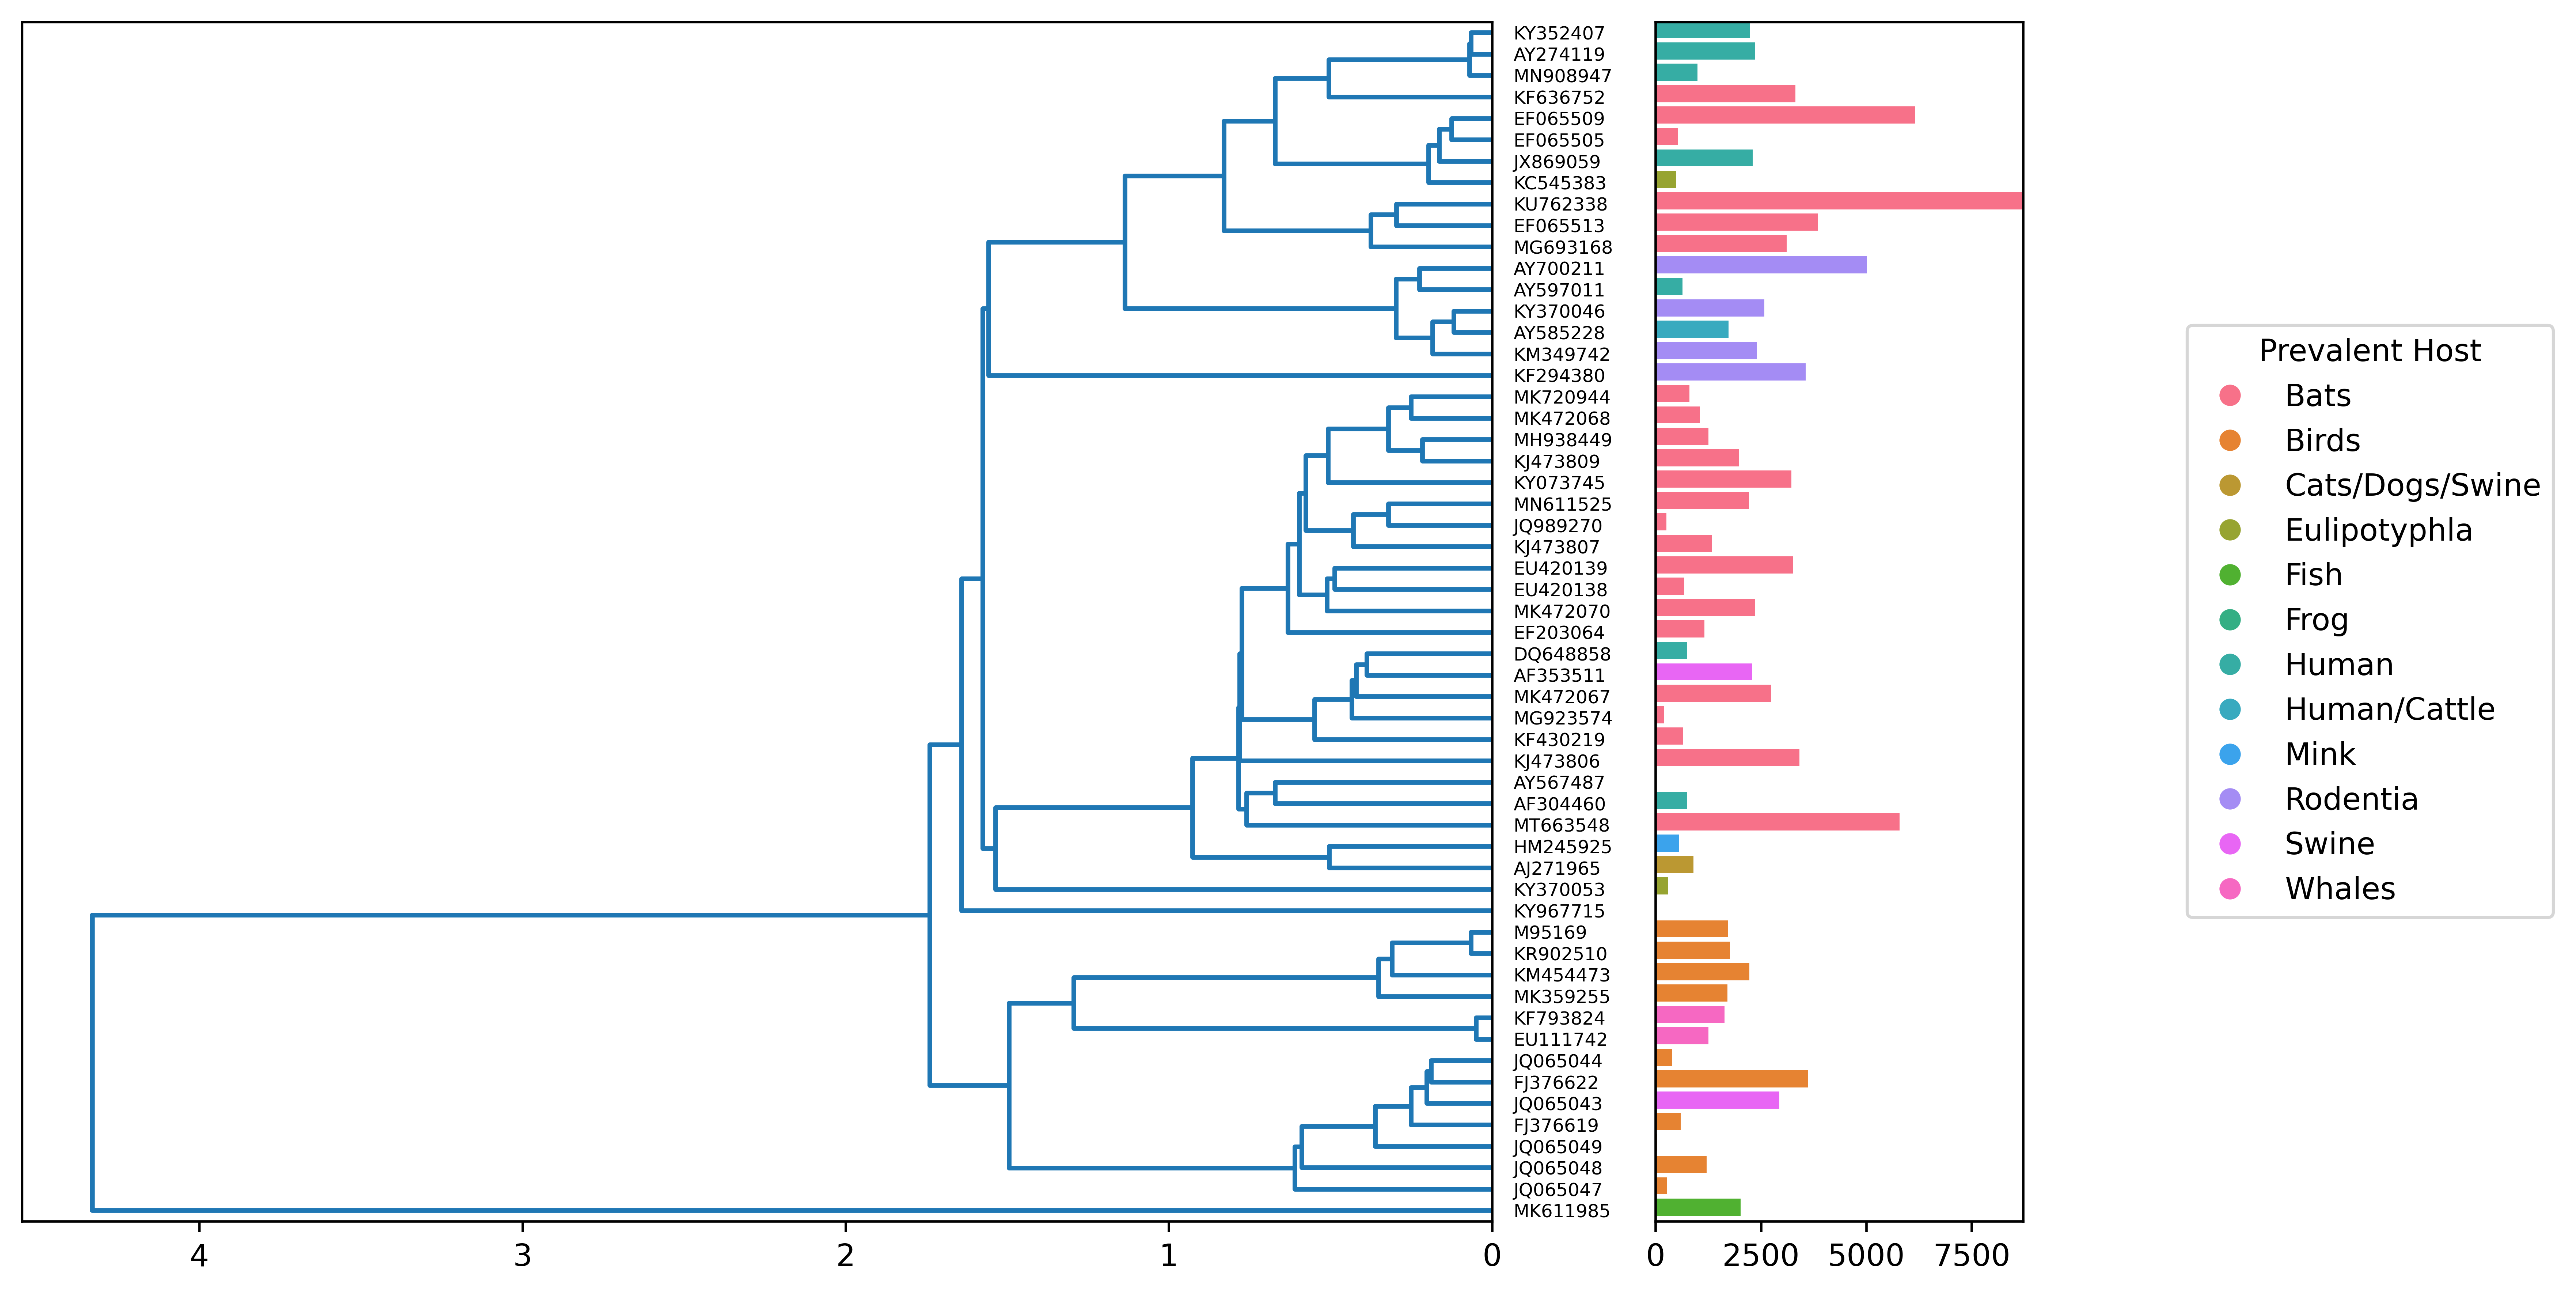

In [133]:
plot_tree_with_annotations(tree_newick_string, length_of_intervals_zdnabert, taxa_db, color_threshold=0);

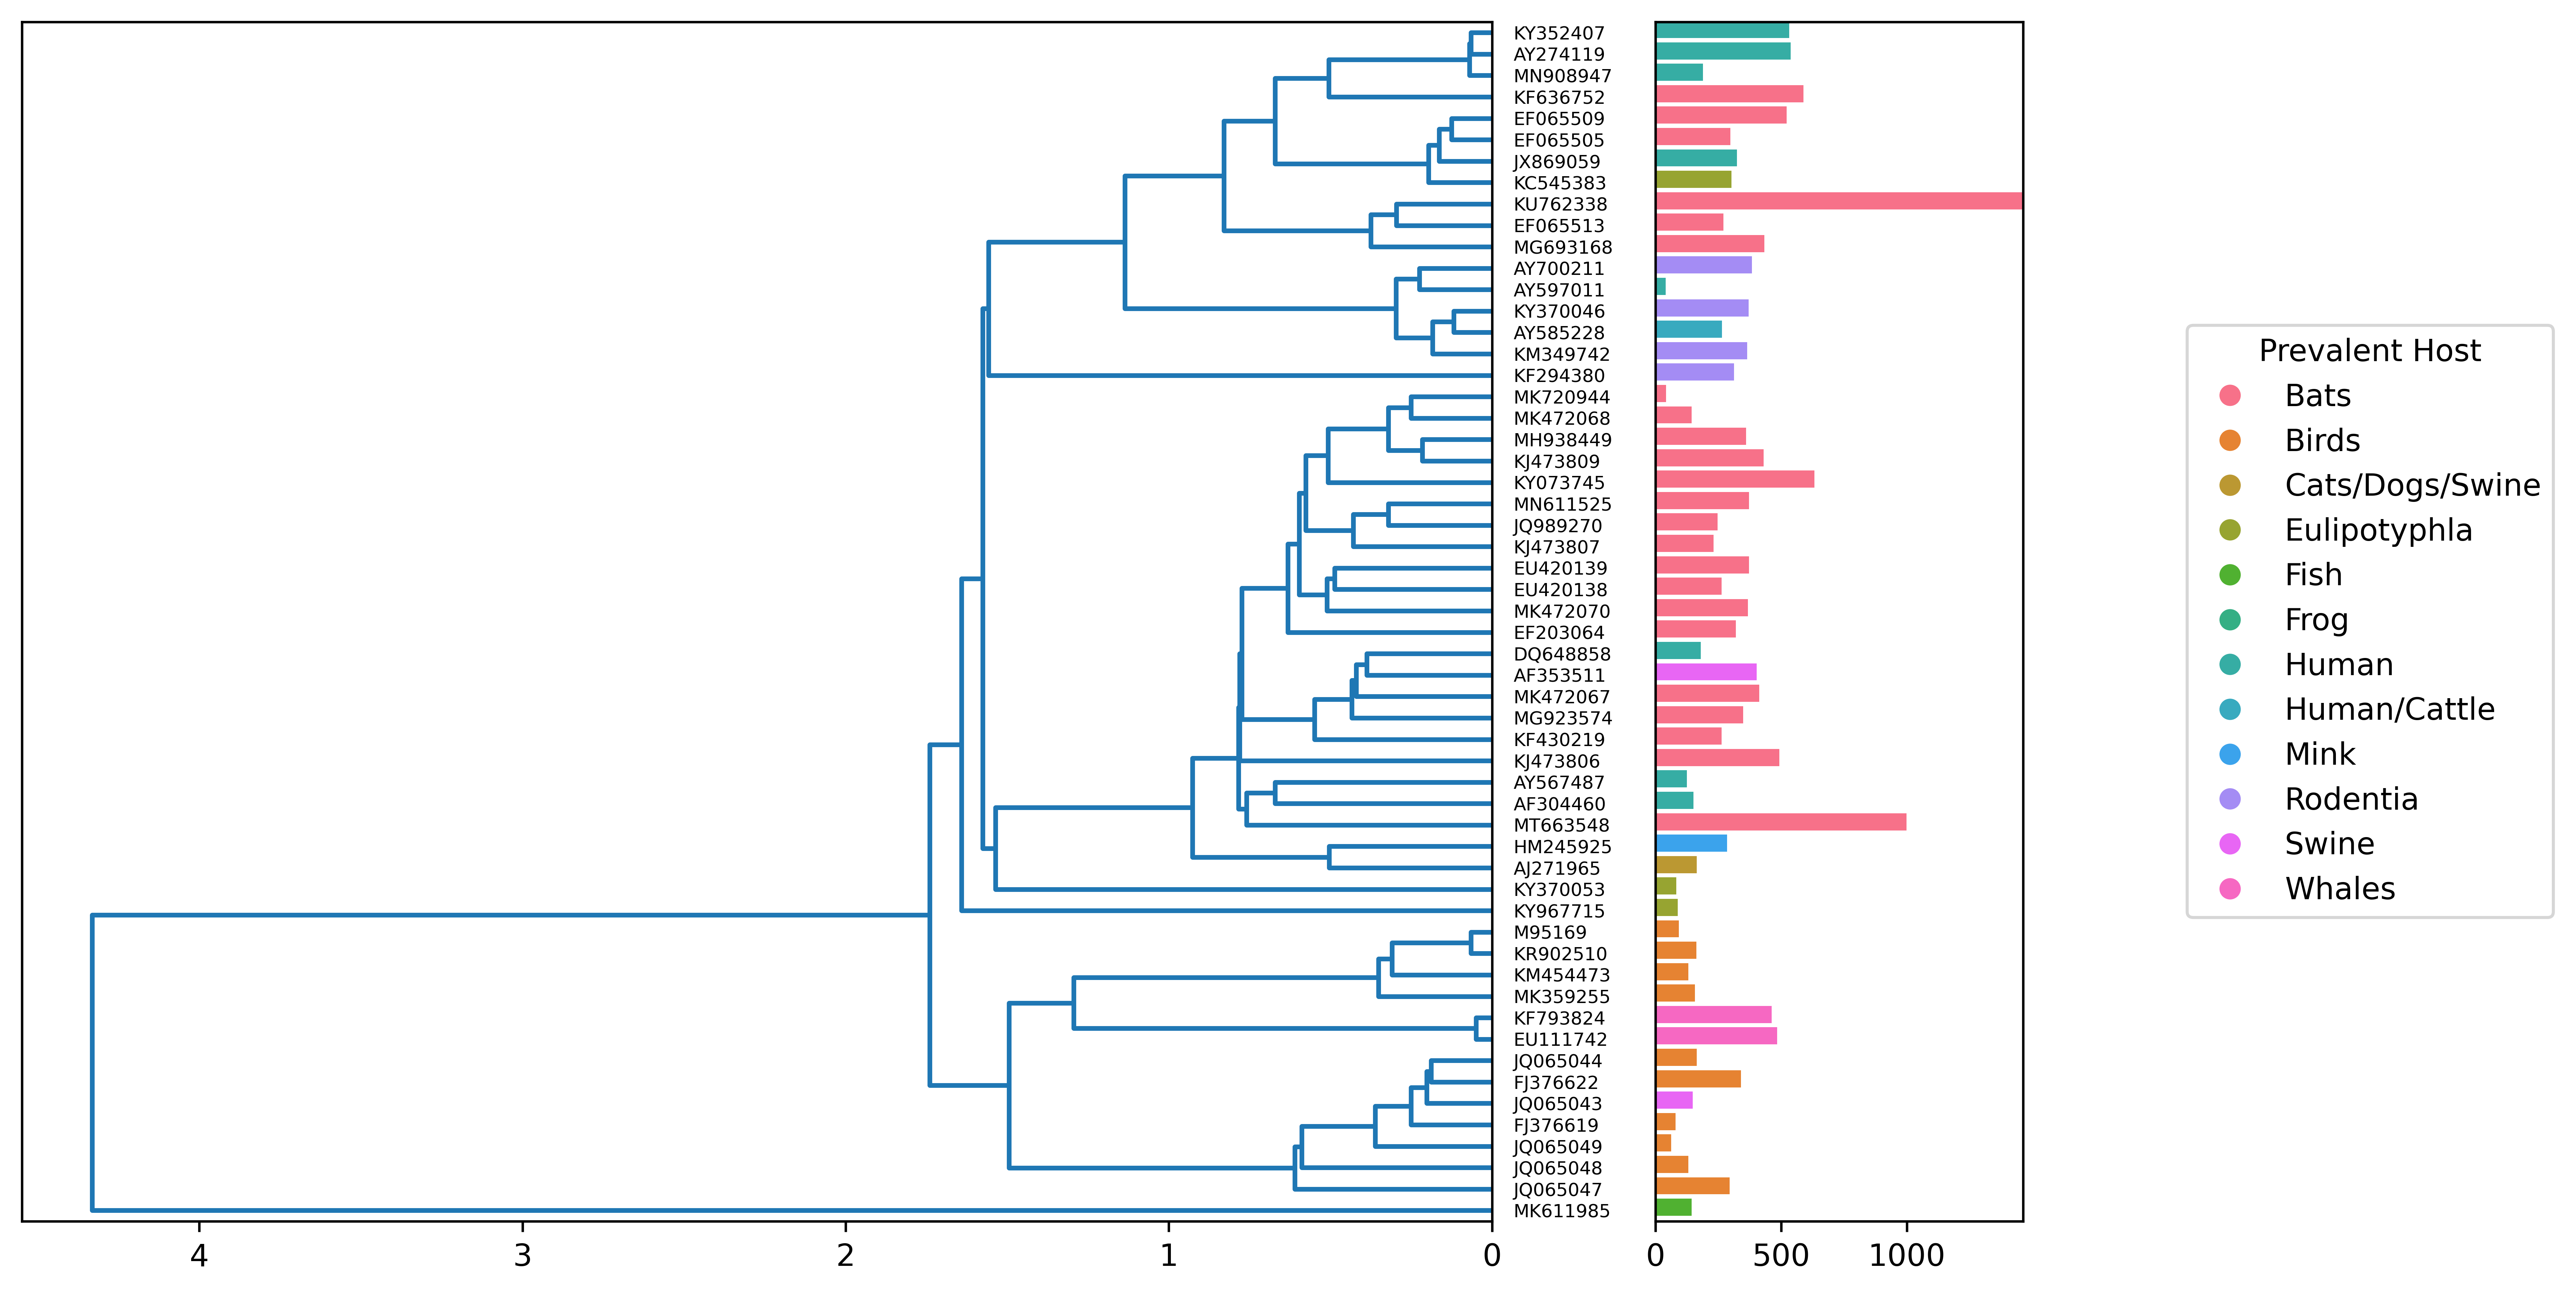

In [129]:
plot_tree_with_annotations(tree_newick_string, length_of_intervals_zhunt, taxa_db, color_threshold=0)

In [ ]:
!zip -r /content/species_gb_files.zip /content/species_gb_files

In [ ]:
from google.colab import files
files.download('/content/species_gb_files.zip')

In [ ]:
def extract_genbank_meta(gb_file: str, virus_name: str) -> pd.DataFrame:
    """
    Extract metadata from a GenBank file and store it in a pandas DataFrame.

    Args:
        gb_file (str): Path to the GenBank file.
        virus_name (str): Name of the virus.

    Returns:
        pd.DataFrame: A DataFrame containing the extracted metadata including accession,
                      description, collection date, geographic location, sequence length, host, and virus name.
    """

    data_list = []
    records = SeqIO.parse(gb_file, 'genbank')

    for record in records:
        try:
            accession = record.id
            description = record.description
            collection_date = record.features[0].qualifiers.get('collection_date', '')
            if not collection_date:
                collection_date = record.annotations.get('date', '')
            if isinstance(collection_date, list):
                collection_date = collection_date[0] if collection_date else ''
            geographic_location = record.features[0].qualifiers.get('country', [''])[0]
            host = next((feature.qualifiers['host'][0] for feature in record.features
                         if feature.type == 'source' and 'host' in feature.qualifiers), '')

            data_list.append({
                'Virus Name': virus_name,
                'Accession': accession,
                'Description': description,
                'Collection Date': collection_date,
                'Geographic Location': geographic_location,
                'Sequence Length': len(record.seq),
                'Host': host
                })

        except Exception as e:
            print(f"Error processing record {record.id}: {e}")

    return pd.DataFrame(data_list)


In [ ]:
!mkdir virus_meta

In [ ]:
# Iterate over the list of GenBank files and extract metadata

directory = '/content/species_gb_files'
file_paths = [os.path.join(directory, file) for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]

all_meta_df = pd.DataFrame()

for gb_file in file_paths:
    # Extracting the virus name from the file path
    virus_name = os.path.basename(gb_file).split('.')[0].replace('_', ' ')  # This assumes names like 'Alphacoronavirus_BT020.gbk'
    df = extract_genbank_meta(gb_file, virus_name)
    df.to_csv(f"/content/virus_meta/{virus_name.replace(' ', '_')}.csv")
    all_meta_df = pd.concat([all_meta_df, df], ignore_index=True)
all_meta_df.to_csv('all_meta_df.csv')